## Trait data curation

**Notebook summary**

This Jupyter Notebook:
- Exports a .csv version on FunFun
- Extracts trait information for species that overlap with our working set and have a consistent Divergent Fungi Actin (DFA) status at the strain level
- Provides the code for the Pub Figure 5


**Context/Goal reminder**
We used the database FunFun as the source of fungal trait information (https://doi.org/10.1111/brv.12570). This database contains a large set of information from different studies and other databases and provides them at the species level. We decided to focus on 6 traits: presence/absence of auxin responsive promoter, spore length, spore width, ascus dehiscence, growth form and trophic mode. 

**Notebook purpose**
In this notebook, we extract trait information from the FunFun database for the 6 traits we want to investigate and for the species of our working that are also present in the FunFun database and that have consistent DFA status at the strain level. Eventually we visualize available trait information and species DFA status onto a species-level phylogenetic tree.

---

### Setup path and environment

In [1]:
setwd('..')


library(dplyr)
library(tidyverse)
library(ggplot2)
library(ggtree)
library(ggtreeExtra)
library(ggnewscale)
library(dplyr)
library(ape)


Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ stringr 1.5.1
✔ tidyr   1.3.0     ✔ forcats 1.0.0
✔ readr   2.1.4     

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts ───────────────────────────────

### Analysis

#### Trait data curation

In [2]:
## Import funfun database
    # we obtained the .csv file of the database by following intrsuction on the github page:https://doi.org/10.1111/brv.12570.

data_base=read.csv('data/step3/FunFun_database_all.csv')
dim(data_base)

[1] 5866  102

In [3]:
    # Select only the trait we are interested in
data_trait=data_base[,c('speciesMatched','ascus_dehiscence','auxinResponsivePromoter_count','growth_form_fg',
                        'spore_length','spore_width','trophic_mode_fg')]

head(data_trait, 5)

,speciesMatched,ascus_dehiscence,auxinResponsivePromoter_count,growth_form_fg,spore_length,spore_width,trophic_mode_fg
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,Armillaria gallica,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph
2,Armillaria gallica,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph
3,Armillaria gallica,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph
4,Armillaria gallica,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph
5,Armillaria gallica,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph


In [4]:
    # Remove any species that doesn't have trait information for at least one trait
data_trait_s=data_trait %>% filter(!if_all(colnames(data_trait[,2:7]), is.na))%>%distinct()
dim(data_trait_s)

[1] 1658    7

In [5]:
## Import working set with DFA information to look for overlap with FunFun
 # We added an extra column to the working_set_w_DFA to add the species in the same format than the one in the FunFun database

data_set=read.csv('data/step3/working_set_w_DFA_sname.csv')
head(data_set,3) # the column $species_short is the species name that matches the format of the FunFun database

,X,Organism_uniprot,n_prot,species_name,species_short,kingdom,phylum,class,order,family,genus,FDA
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,[Candida] intermedia,10617,[Candida] intermedia,Candida intermedia,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Metschnikowiaceae,Candida,No
2,2,[Torrubiella] hemipterigena,11065,[Torrubiella] hemipterigena,Torrubiella hemipterigena,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Clavicipitaceae,Torrubiella,Yes
3,3,Aaosphaeria arxii CBS 175.79,13815,Aaosphaeria arxii CBS 175.79,Aaosphaeria arxii,Fungi,Ascomycota,Dothideomycetes,Pleosporales,NA,Aaosphaeria,No


In [6]:
## Obtain species list in working set with at least one trait available
spe_inter=intersect(data_trait_s$speciesMatched, data_set$species_short)
length(spe_inter)

[1] 143

In [7]:
    # subset trait information and DFA information fo species that have both information
data_trait_sub=subset(data_trait_s,data_trait_s$speciesMatched%in%spe_inter)

data_DFA_sub=subset(data_set, data_set$species_short%in%spe_inter)

dim(data_trait_sub)
dim(data_DFA_sub)

[1] 181   7

[1] 209  12

In [8]:
## Counting number of strain per species
    # Some species in the working set might be associated with multiple strains. We want to identify whcih species are associated with multiple strains and verify if the strains have the same DFA status. If not these species will be removed from the study.

nb_strain=data_DFA_sub %>% count(species_short,name='count_str')

head(nb_strain,10)


,species_short,count_str
,<chr>,<int>
1,Agaricus bisporus,1
2,Amanita muscaria,1
3,Amanita thiersii,1
4,Armillaria gallica,1
5,Armillaria ostoyae,1
6,Arthrobotrys oligospora,1
7,Arthroderma benhamiae,1
8,Aspergillus clavatus,1
9,Aspergillus flavus,3


In [9]:
 # Identify species with 1 or more strains

spe_1_str=subset(nb_strain, nb_strain$count_str ==1)
spe_mult_str=subset(nb_strain, nb_strain$count_str >1)

dim(spe_1_str)
dim(spe_mult_str)

[1] 107   2

[1] 36  2

In [10]:
 # Checking DFA status for the strains of the same species
 # We create a dataframne that indicates for each species with multiple strain if the DFA status of all the strain is the same or not - if the status is the same it returns 'Yes' or 'No' to describe if the species possess or don't possess DFA

DFA_mult_strain=subset(data_DFA_sub, data_DFA_sub$species_short%in%spe_mult_str$species_short)

spe_mult=c(unique(DFA_mult_strain$species_short)) # get the lst of species name with multiple strains

data_DFA_status=data.frame() # initiate empty dataframe 

for (i in 1:length(spe_mult)){
  spe=spe_mult[i]
  dat=subset(DFA_mult_strain, DFA_mult_strain$species_short==spe)
  vec=c(dat$DFA)
  if(length(unique(vec))==1){
    stat=unique(vec)
  } else {
    stat='different DFA status'
  }
  
  df_temp=data.frame('species'=spe,
                     'DFA_stat'=stat)
  data_DFA_status=rbind(data_DFA_status,df_temp)
  
}

data_DFA_status

species,FDA_stat
<chr>,<chr>
Aspergillus flavus,No
Aspergillus fumigatus,different FDA status
Aspergillus kawachii,No
Aspergillus niger,different FDA status
Aureobasidium pullulans,different FDA status
Beauveria bassiana,No
Blumeria graminis,different FDA status
Botryotinia fuckeliana,different FDA status
Coccidioides immitis,different FDA status


In [11]:
 # Now we remove the species that have inconsistent strain DFA information

species_good_DFA=subset(data_DFA_status, data_DFA_status$DFA_stat!='different DFA status')
spe_good=c(species_good_DFA$species,spe_1_str$species_short)
spe_good
length(spe_good)

[1] "Aspergillus flavus"             "Aspergillus kawachii"          
  [3] "Beauveria bassiana"             "Colletotrichum higginsianum"   
  [5] "Cordyceps militaris"            "Dichomitus squalens"           
  [7] "Fusarium oxysporum"             "Gibberella fujikuroi"          
  [9] "Metarhizium robertsii"          "Neurospora crassa"             
 [11] "Neurospora tetrasperma"         "Puccinia graminis"             
 [13] "Puccinia striiformis"           "Pyrenophora teres"             
 [15] "Rhizopus microsporus"           "Rhodotorula toruloides"        
 [17] "Saccharomyces cerevisiae"       "Thanatephorus cucumeris"       
 [19] "Trichoderma asperellum"         "Trichoderma harzianum"         
 [21] "Trichophyton rubrum"            "Verticillium dahliae"          
 [23] "Yarrowia lipolytica"            "Agaricus bisporus"             
 [25] "Amanita muscaria"               "Amanita thiersii"              
 [27] "Armillaria gallica"             "Armillaria ostoyae"            
 [29] "Arthrobotrys oligospora"        "Arthroderma benhamiae"         
 [31] "Aspergillus clavatus"           "Aspergillus ruber"             
 [33] "Aspergillus terreus"            "Bimuria novae-zelandiae"       
 [35] "Bionectria ochroleuca"          "Bipolaris oryzae"              
 [37] "Bipolaris victoriae"            "Blastomyces dermatitidis"      
 [39] "Byssothecium circinans"         "Cadophora sp."                 
 [41] "Ceratocystis fimbriata"         "Ceriporiopsis subvermispora"   
 [43] "Chaetomium globosum"            "Choanephora cucurbitarum"      
 [45] "Claviceps purpurea"             "Coemansia reversa"             
 [47] "Colletotrichum gloeosporioides" "Colletotrichum graminicola"    
 [49] "Conidiobolus coronatus"         "Coniophora puteana"            
 [51] "Coprinellus micaceus"           "Coprinopsis cinerea"           
 [53] "Cyberlindnera jadinii"          "Cylindrobasidium torrendii"    
 [55] "Dactylellina haptotyla"         "Debaryomyces hansenii"         
 [57] "Diversispora epigaea"           "Dothistroma septosporum"       
 [59] "Endogone sp."                   "Epicoccum nigrum"              
 [61] "Eutypa lata"                    "Exophiala spinifera"           
 [63] "Exophiala xenobiotica"          "Exserohilum turcicum"          
 [65] "Fibroporia radiculosa"          "Fistulina hepatica"            
 [67] "Fusarium culmorum"              "Galerina marginata"            
 [69] "Gibberella zeae"                "Gigaspora rosea"               
 [71] "Gloeophyllum trabeum"           "Grifola frondosa"              
 [73] "Grosmannia clavigera"           "Gymnopus androsaceus"          
 [75] "Hebeloma cylindrosporum"        "Hydnomerulius pinastri"        
 [77] "Jaapia argillacea"              "Laccaria amethystina"          
 [79] "Laccaria bicolor"               "Lasallia pustulata"            
 [81] "Lichtheimia corymbifera"        "Macrophomina phaseolina"       
 [83] "Malassezia sympodialis"         "Metarhizium acridum"           
 [85] "Microdochium bolleyi"           "Mixia osmundae"                
 [87] "Monilinia laxa"                 "Moniliophthora perniciosa"     
 [89] "Oidiodendron maius"             "Paxillus involutus"            
 [91] "Paxillus rubicundulus"          "Penicillium chrysogenum"       
 [93] "Penicillium oxalicum"           "Phaeoacremonium minimum"       
 [95] "Phaeosphaeria nodorum"          "Phanerochaete carnosa"         
 [97] "Phlebiopsis gigantea"           "Phycomyces blakesleeanus"      
 [99] "Pisolithus microcarpus"         "Pleomassaria siparia"          
[101] "Pleurotus ostreatus"            "Pseudozyma hubeiensis"         
[103] "Pyronema omphalodes"            "Rhizophagus clarus"            
[105] "Rhizopus stolonifer"            "Rozella allomycis"             
[107] "Schizophyllum commune"          "Scleroderma citrinum"          
[109] "Sclerotinia sclerotiorum"       "Serendipita indica"            
[111] "Serendipita vermifera"          "Sp

[1] 130

In [12]:
 #In DFA information table
data_DFA_sub_good=subset(data_DFA_sub, data_DFA_sub$species_short%in%spe_good)

 #In trait table

data_trait_sub_good=subset(data_trait_sub, data_trait_sub$speciesMatched%in%spe_good)

dim(data_DFA_sub_good)
dim(data_trait_sub_good)

[1] 171  12

[1] 161   7

In [13]:
head(data_DFA_sub_good,3)

,X,Organism_uniprot,n_prot,species_name,species_short,kingdom,phylum,class,order,family,genus,FDA
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
8,8,Agaricus bisporus var. burnettii (strain JB137-S8 / ATCC MYA-4627 / FGSC 10392) (White button mushroom),10948,Agaricus bisporus var. burnettii,Agaricus bisporus,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,Agaricus,No
20,20,Amanita muscaria (strain Koide BX008),17633,Amanita muscaria,Amanita muscaria,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Amanitaceae,Amanita,Yes
21,21,Amanita thiersii Skay4041,10068,Amanita thiersii Skay4041,Amanita thiersii,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Amanitaceae,Amanita,Yes


In [14]:
head(data_trait_sub_good,3)

,speciesMatched,ascus_dehiscence,auxinResponsivePromoter_count,growth_form_fg,spore_length,spore_width,trophic_mode_fg
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,Armillaria gallica,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph
3,Schizophyllum commune,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph
4,Amanita muscaria,NA,NA,Agaricoid,NA,NA,Symbiotroph


In [15]:
# Saving trait information

species_DFA=data.frame(data_DFA_sub_good$species_short,data_DFA_sub_good$phylum,data_DFA_sub_good$DFA) # first we creat a table only with species, phylum and DFA information
colnames(species_DFA)=c('speciesMatched','Phylum','DFA')
species_DFA_s=species_DFA%>%distinct()

trait_info_species_and_DFA=left_join(species_DFA, data_trait_sub_good, by='speciesMatched')%>%distinct()
head(trait_info_species_and_DFA,5)

write.csv(trait_info_species_and_DFA,'results/step3/traits_DFA_info.csv')

Warning message in left_join(species_FDA, data_trait_sub_good, by = "speciesMatched"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 38 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


,speciesMatched,Phylum,FDA,ascus_dehiscence,auxinResponsivePromoter_count,growth_form_fg,spore_length,spore_width,trophic_mode_fg
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,Agaricus bisporus,Basidiomycota,No,NA,NA,NA,9.5,7.8,NA
2,Agaricus bisporus,Basidiomycota,No,NA,NA,NA,8.5,5.3,NA
3,Amanita muscaria,Basidiomycota,Yes,NA,NA,Agaricoid,NA,NA,Symbiotroph
4,Amanita muscaria,Basidiomycota,Yes,NA,NA,Agaricoid,9.0,6.5,Symbiotroph
5,Amanita muscaria,Basidiomycota,Yes,NA,0,Agaricoid,NA,NA,Symbiotroph


#### Tree representation of species with DFA status and trait information (Figure 5)

On this species-level tree, we aim to represent for each species, its DFA status (presence/absence) as well as whether or not a trait information is available for a species for a given trait.
Before being able to build the tree, there are a couple of necessary steps to transform and reformat the data:
    - transform the trait as information as a binary information yes or no to indicate whether or not a trait information is available
    - get all the species name format homogeneized across the trait table, the DFA table and the tree
    - combine the trait and DFA table and collapse species information into one row per species (as the same species may be associated with multiple rows in the FunFun database, with individual rows being associated with individual trait information)
    - reformat/gather trait information to fit the ggplot2 data format to be able to map the heatmap data onto the tree 

In [16]:
 ## Import the tree from TimeTree generated using the species input of the species_short list of data_DFA_sub_good

tree=read.tree('data/step3/species_trait_tree_final.nwk')
tree_tip=tree$tip.label

In [17]:
 ## Trait data reformating (to create the data.frame that will be used to map information onto the tree)
    # We need to reformat the trait data to indicate only if trait information is present (yes) or absent (no) for each species
    # also we need to reformat the name of species to match the tree_tip format

species_n=data_trait_sub_good[,1]
species_nf=sub(" ","_",species_n)

trait_to_mod=data_trait_sub_good[,2:7]

trait_to_mod[!is.na(trait_to_mod)]<-'Yes'
trait_good_formated=cbind(species_nf,trait_to_mod)
trait_good_formated[is.na(trait_good_formated)]<-'No'

colnames(trait_good_formated)=c('tip.label',colnames(trait_good_formated[,2:7]))

head(trait_good_formated,10)

,tip.label,ascus_dehiscence,auxinResponsivePromoter_count,growth_form_fg,spore_length,spore_width,trophic_mode_fg
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Armillaria_gallica,No,No,Yes,No,No,Yes
3,Schizophyllum_commune,No,No,Yes,No,No,Yes
4,Amanita_muscaria,No,No,Yes,No,No,Yes
31,Paxillus_involutus,No,No,Yes,No,No,Yes
39,Chaetomium_globosum,No,No,Yes,No,No,Yes
40,Cyberlindnera_jadinii,No,No,Yes,No,No,Yes
42,Fusarium_culmorum,No,No,Yes,No,No,Yes
43,Fusarium_oxysporum,No,No,Yes,No,No,Yes
50,Neurospora_crassa,No,No,Yes,No,No,Yes


In [18]:
## DFA data formating
 # We reformat the species names with the DFA information

colnames(species_DFA_s)=c('tip.label','Phylum','DFA')
species_DFA_s$tip.label=sub(' ','_',species_DFA_s$tip.label)

head(species_DFA_s,10)


,tip.label,Phylum,FDA
,<chr>,<chr>,<chr>
1,Agaricus_bisporus,Basidiomycota,No
2,Amanita_muscaria,Basidiomycota,Yes
3,Amanita_thiersii,Basidiomycota,Yes
4,Armillaria_gallica,Basidiomycota,Yes
5,Armillaria_ostoyae,Basidiomycota,Yes
6,Arthrobotrys_oligospora,Ascomycota,Yes
7,Arthroderma_benhamiae,Ascomycota,Yes
8,Aspergillus_clavatus,Ascomycota,Yes
9,Aspergillus_flavus,Ascomycota,No


In [19]:
## We combine trait and DFA data into a single dataframe

data_for_tree=left_join(species_DFA_s,trait_good_formated,by='tip.label')%>%distinct()

head(data_for_tree,10)

,tip.label,Phylum,FDA,ascus_dehiscence,auxinResponsivePromoter_count,growth_form_fg,spore_length,spore_width,trophic_mode_fg
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Agaricus_bisporus,Basidiomycota,No,No,No,No,Yes,Yes,No
2,Amanita_muscaria,Basidiomycota,Yes,No,No,Yes,No,No,Yes
3,Amanita_muscaria,Basidiomycota,Yes,No,No,Yes,Yes,Yes,Yes
4,Amanita_muscaria,Basidiomycota,Yes,No,Yes,Yes,No,No,Yes
5,Amanita_thiersii,Basidiomycota,Yes,No,No,Yes,No,No,Yes
6,Armillaria_gallica,Basidiomycota,Yes,No,No,Yes,No,No,Yes
7,Armillaria_ostoyae,Basidiomycota,Yes,No,No,Yes,Yes,Yes,Yes
8,Arthrobotrys_oligospora,Ascomycota,Yes,No,Yes,No,No,No,No
9,Arthroderma_benhamiae,Ascomycota,Yes,No,Yes,Yes,No,No,Yes


In [20]:
## Obtain the list of species that are present in the tree and in the data_for_tree 

species_all=intersect(tree_tip, data_for_tree$tip.label)
length(species_all)

[1] 102

In [21]:
## Trim tree 
tree_pruned=keep.tip(tree,species_all)


In [22]:
## Collapse species trait information in a single row/species - in some cases 1 species may have trait information distributed on multiple rows and we collapse them into a single row

tax_trait_DFA=subset(data_for_tree, data_for_tree$tip.label%in%species_all)

tax_trait_DFA_simp=data.frame()

for(i in 1:length(species_all)){
  dat=subset(tax_trait_DFA, tax_trait_DFA$tip.label==species_all[i])
  if (dim(dat)[1]==1){
    dat_temp=dat
    tax_trait_DFA_simp=rbind(tax_trait_DFA_simp,dat_temp)
    
  } else {
    dat_temp_2=matrix(nrow=1,ncol=9)
    colnames(dat_temp_2)=colnames(tax_trait_DFA)
    dat_temp_2[1,1]=species_all[i]
    dat_temp_2[1,2]=c(unique(dat[,2]))
    dat_temp_2[1,3]=c(unique(dat[,2]))
    for (j in 3:dim(tax_trait_DFA)[2]){
      trait=c(unique(dat[,j]))
      if (length(trait)==1){
        dat_temp_2[1,j]=trait 
      } else {
        dat_temp_2[1,j]='Yes'
      }
    }
    dat_temp_df=as.data.frame(dat_temp_2)
    tax_trait_DFA_simp=rbind(tax_trait_DFA_simp, dat_temp_df)
  }
}

head(tax_trait_DFA_simp,15)

,tip.label,Phylum,FDA,ascus_dehiscence,auxinResponsivePromoter_count,growth_form_fg,spore_length,spore_width,trophic_mode_fg
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
117,Rhizophagus_clarus,Mucoromycota,Yes,No,No,No,Yes,Yes,No
45,Diversispora_epigaea,Mucoromycota,Yes,No,No,No,Yes,Yes,No
66,Gigaspora_rosea,Mucoromycota,No,No,No,No,Yes,Yes,No
142,Tremella_mesenterica,Basidiomycota,No,No,Yes,Yes,No,No,Yes
132,Sphaerobolus_stellatus,Basidiomycota,Yes,No,Yes,No,No,No,No
87,Moniliophthora_perniciosa,Basidiomycota,No,No,Yes,Yes,No,No,Yes
37,Coprinopsis_cinerea,Basidiomycota,No,No,Yes,Yes,No,No,Yes
1,Laccaria_bicolor,Basidiomycota,Yes,No,Yes,No,Yes,Yes,No
11,Agaricus_bisporus,Basidiomycota,No,No,No,No,Yes,Yes,No


In [23]:
## Finalize data reformating/gathering for second layer of mapping for trait (heatmap)
    # determine phylum levels
    # gather traits
    #determine traits levels

tax_trait_DFA_simp$Phylum=factor(tax_trait_DFA_simp$Phylum,levels=c('Ascomycota','Basidiomycota','Mucoromycota','Zoopagomycota',
                                                  'Cryptomycota'))

tax_trait_g=gather(tax_trait_DFA_simp,Trait,Status,ascus_dehiscence:trophic_mode_fg)
tax_trait_g$Trait=factor(tax_trait_g$Trait,levels=c("growth_form_fg","trophic_mode_fg",
                                                    "spore_length" ,"spore_width",
                                                    'ascus_dehiscence',"auxinResponsivePromoter_count"))

Warning message:
“The following column names/name: Phylum, FDA are/is the same to tree
data, the tree data column names are : label, y, angle, Phylum, FDA,
ascus_dehiscence, auxinResponsivePromoter_count, growth_form_fg,
spore_length, spore_width, trophic_mode_fg, xmaxtmp.”
ℹ invalid tbl_tree object. Missing column: parent,node.

ℹ invalid tbl_tree object. Missing column: parent,node.



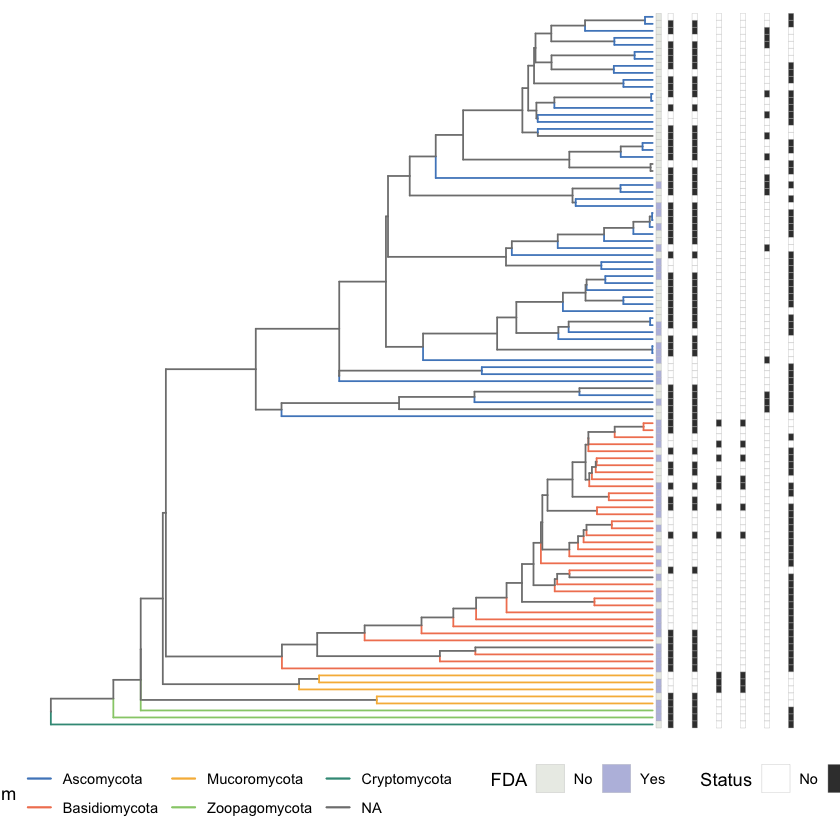

In [25]:
## Tree - Figure 5

 # Color palette
accent_phylum <- c('#5088C5', '#F28360', '#F7B846', '#97CD78',
                    '#3B9886')

 #base tree

tree_base=ggtree(tree_pruned, branch.length="branch.length")  %<+% tax_trait_DFA_simp

 # add branch color for phylum
tree_base_col=tree_base+ aes(color=Phylum)+
  scale_color_manual(values=c(accent_phylum))+
  theme(legend.position = 'bottom')

 # add DFA information as a single heatmap to map presence/absence of DFA for each species
tree_base_fsa= tree_base_col + geom_fruit(geom=geom_tile,
                                          mapping=aes( y=tip.label, fill=DFA, width=7, height=1),
                                          color = "gray", offset=0.01) +
               scale_fill_manual(values=c('#EBEDE8','#BABEE0'))

 # add trait absence/presence information
tree_trait=tree_base_fsa + new_scale_fill()+
  geom_fruit(data=tax_trait_g,
             geom=geom_tile,
             mapping=aes( y=tip.label, x=Trait, fill=Status, width=7, height=1),
             color = "gray", offset=0.01)+
  scale_fill_manual(values=c('white','gray23'))

tree_trait



In [26]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/manonmorin/miniconda3/envs/R_good_env/lib/libopenblasp-r0.3.24.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ape_5.7-1         ggnewscale_0.4.9  ggtreeExtra_1.8.0 ggtree_3.6.0     
 [5] forcats_1.0.0     stringr_1.5.1     purrr_1.0.2       readr_2.1.4      
 [9] tidyr_1.3.0       tibble_3.2.1      ggplot2_3.4.4     tidyverse_1.3.1  
[13] dplyr_1.1.4      

loaded via a namespace (and not attached):
 [1] httr_1.4.7         jsonlite_1.8.7     modelr_0.1.11      yulab.utils_0.1.0 
 [5] cellranger_1.1.0   pillar_1.9.0       backports_1.4.1    lattice_0.22-5    
 [9] glue_1.6.2         uuid_1.1-1         digest_0.6.33      rvest_1.0.3       
[13] colorspace_2.1-0   ggfun_0